In the first lessons of the second part of [Practical Deep Learning for coders](https://course.fast.ai/Lessons/part2.html) Jeremy explains how Stable Diffusion works and uses Hugging Face's diffusers library as a demonstration. You can check the code [here](https://github.com/fastai/diffusion-nbs/blob/master/Stable%20Diffusion%20Deep%20Dive.ipynb).

As a homework Jeremy asks us to implement: **Negative prompts** and **Image to Image**.

That's what I will be trying to do in this notebook.

Let's get started.


# Setup:

This notebook assumes that you are already familiar with the diffusers library. If you are not make sure to check the first 2 lessons of the second part of [Practical Deep Learning for coders](https://course.fast.ai/Lessons/part2.html).

If you want to run this locally make sure to have an Nvidia GPU, if you don't you can run it on colab (make sure you are a GPU on colab too).

First we install the required libraries:

In [14]:
! pip install -Uqq fastcore transformers diffusers

Now we import the needed packages and we login to hugging face hub [using our token](https://huggingface.co/docs/hub/security-tokens).

In [15]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"


## Pre loading models

Stable diffusion model depends on three things:

- `CLIP model` - For converting prompts to embeddings which gives the visual clue.
- `VAE (Variational Auto Encoder)` - To reduce the dimensions of the original image for faster computations.
- `UNET` - The model which takes a noisy image and embedded prompt to predict the noise present in the image.



### Importing diffusion UNet and VAE


In [16]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

### CLIP

In this case, we are using a CLIP model which converts the text prompt into an embedding. To do this using transformers library ,we need two things -
- 1) `Tokenizer` - This function takes the raw text, breaks it into words (or subwords if the words are long enough) and then converts them into numeric forms
- 2) `text_encoder` - This function takes the tokenizer output and converts it into embeddings

In [17]:
# Loading clip tokenizer and encoder
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

### Scheduler

This tells the model on how much noise to add at a given timestep

In [18]:
beta_start,beta_end = 0.00085,0.012
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)

Text(0.5, 1.0, 'Schedular routine')

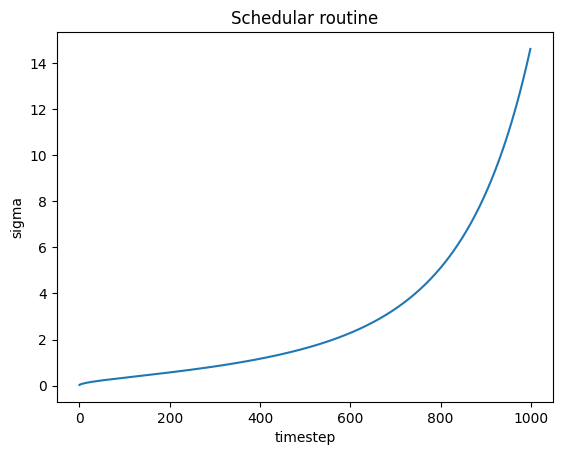

In [19]:
plt.plot(scheduler.timesteps, scheduler.sigmas[:-1])
plt.xlabel("timestep")
plt.ylabel("sigma")
plt.title("Schedular routine")

## Simple text to image inference

First we need some helper functions:

In [36]:
def load_image(p):
    '''
    Function to load images from a defined path
    '''
    return Image.open(p).convert('RGB').resize((512,512))

def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16)
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

Now to the main function:

In [37]:
def prompt_2_img(prompts, g=7.5, seed=100, steps=70, dim=512, save_int=False):
    """
    Diffusion process to convert prompt to image
    """

    # Defining batch size
    bs = len(prompts)

    # Converting textual prompts to embedding
    text = text_enc(prompts)

    # Adding an unconditional prompt , helps in the generation process
    uncond =  text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])

    # Setting the seed
    if seed: torch.manual_seed(seed)

    # Initiating random noise
    latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))

    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)

    # Adding noise to the latents
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    # Iterating through defined steps
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)

        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

        # Performing Guidance
        pred = u + g*(t-u)

        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample

        # Saving intermediate images
        if save_int:
            if not os.path.exists(f'./steps'):
                os.mkdir(f'./steps')
            latents_to_pil(latents)[0].save(f'steps/{i:04}.jpeg')

    # Returning the latent representation to output an image of 3x512x512
    return latents_to_pil(latents)

Let’s see if the function works as intended.

<ipython-input-37-340cf93fbe29>:20: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))


  0%|          | 0/70 [00:00<?, ?it/s]

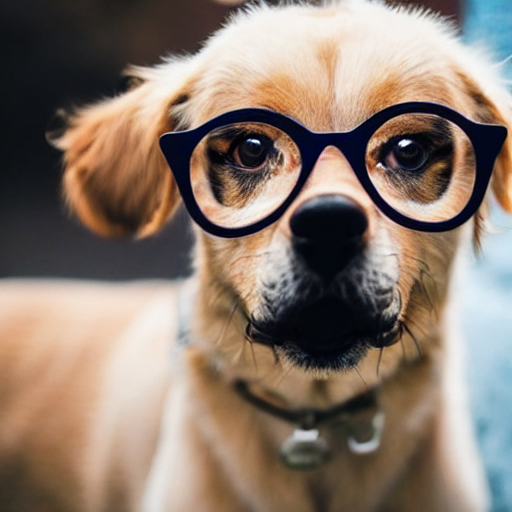

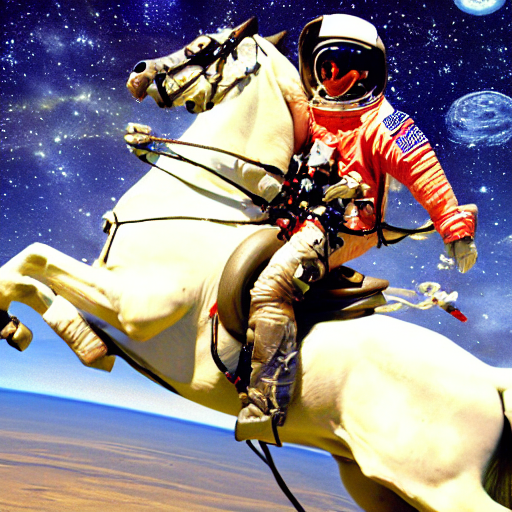

In [43]:
images = prompt_2_img(["A dog wearing glasses", "a photograph of an astronaut riding a horse"], save_int=False)
for img in images:display(img)

Let’s take a deeper dive at the parameters of the function.
1. `prompt` - this is the textual prompt we pass through to generate an image.
2. `g` or guidance scale - It’s a value that determines how close the image should be to the textual prompt. This is related to a technique called [Classifier free guidance](https://sander.ai/2022/05/26/guidance.html) which improves the quality of the images generated. The higher the value of the guidance scale, more close it will be to the textual prompt
3. `seed` - This sets the seed from which the initial Gaussian noisy latents are generated
4. `steps` - Number of de-noising steps taken for generating the final latents.
5. `dim` - dimension of the image, for simplicity we are currently generating square images, so only one value is needed
6. `save_int` - This is optional, a boolean flag, if we want to save intermediate latent images, helps in visualization.

Let’s visualize this process of generation from noise to the final image.

In [44]:
## Creating image through prompt_2_img modified function
images = prompt_2_img(["A dog wearing glasses"], save_int=True)

## Converting intermediate images to video
!ffmpeg -v 1 -y -f image2 -framerate 20 -i steps/%04d.jpeg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4

## Deleting intermediate images
shutil.rmtree(f'./steps/')

## Displaying video output
mp4 = open('out.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

<ipython-input-37-340cf93fbe29>:20: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))


  0%|          | 0/70 [00:00<?, ?it/s]

# Negative Prompt:

## What is negative prompting?

A negative prompt is an additional capability we can add to our model to tell the stable diffusion model what we don’t want to see in the generated image. This feature is popular to remove anything a user doesn’t want to see from the original generated image.

## Implementing Negative prompt

The implentation is simple as straight forward. We saw that in order to generate an image from a prompt we use the embedding of the prompt to generate one noisy latent and we also use the embedding of the empty string `""` to generate another noisy latent and we then subtract them from each other (using the guidance parameter). To implement negative prompt we simply replace the empty string with our negative prompts. So we will add a new parameter `negative_prompts` to our function `prompt_2_img` which will replace the unconditional embedding.

In [51]:
def prompt_2_img(prompts, neg_prompts = None, g=7.5, seed=100, steps=70, dim=512, save_int=False):
    """
    Diffusion process to convert prompt to image
    """

    # Defining batch size
    bs = len(prompts)

    # Converting textual prompts to embedding
    text = text_enc(prompts)

    # Adding an unconditional prompt , helps in the generation process
    if not neg_prompts: uncond =  text_enc([""] * bs, text.shape[1])
    else: uncond =  text_enc(neg_prompts, text.shape[1])
    emb = torch.cat([uncond, text])

    # Setting the seed
    if seed: torch.manual_seed(seed)

    # Initiating random noise
    latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))

    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)

    # Adding noise to the latents
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    # Iterating through defined steps
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)

        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

        # Performing Guidance
        pred = u + g*(t-u)

        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample

        # Saving intermediate images
        if save_int:
            if not os.path.exists(f'./steps'): os.mkdir(f'./steps')
            latents_to_pil(latents)[0].save(f'steps/{i:04}.jpeg')

    # Returning the latent representation to output an image of 3x512x512
    return latents_to_pil(latents)

Let's put it to test

<ipython-input-51-732cee26ebc1>:21: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

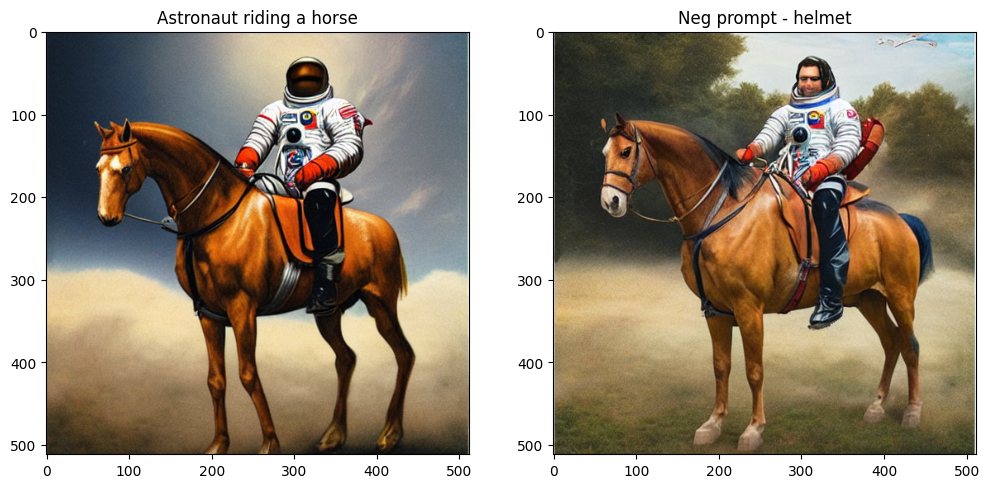

In [64]:
## Image without neg prompt
images = [None, None]
images[0] = prompt_2_img(prompts = ["an astronaut riding a horse"], neg_prompts=[""],steps=70, save_int=False)[0]
images[1] = prompt_2_img(prompts = ["an astronaut riding a horse"], neg_prompts=["helmet"],steps=70, save_int=False)[0]

## Plotting side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for c, img in enumerate(images):
    axs[c].imshow(img)
    if c == 0 : axs[c].set_title(f"Astronaut riding a horse")
    else: axs[c].set_title(f"Neg prompt - helmet")

# Image to Image

## What is an image to image pipeline?
As seen above, `prompt_2_img` functions start generating an image from random gaussian noise, but what if we feed an initial seed image to guide the diffusion process? This is exactly how the image to image pipeline works. Instead of purely relying on text conditioning for the output image, we can use an initial seed image mix it with some noise (which can be guided by a strength parameter), and then run the diffusion loop.

![image](https://drive.google.com/uc?id=1JgAn7kGtrZK-i0YE7O6DCwhIBJAM5kAB)

## Implementing image to image:

we will create a modified `promt_2_img` function called `prompt_and_img_2_img` which have two new parameters:
- `starting_img`: this represents the original image that we will start with as a noisy latent (instead of a completely random noisy latent)
- `strength`: a parameters that ranges from 0 to 1 and determines how similar the final image is to the original one.

In [65]:
def prompt_and_img_2_img(prompt, starting_img, neg_prompts=None, g=7.5, seed=100, strength =0.8, steps=50, dim=512, save_int=False):
    """
    Diffusion process to convert prompt to image
    """
    # Converting textual prompts to embedding
    text = text_enc(prompt) # we only assume one prompt

    # Adding an unconditional prompt , helps in the generation process
    if not neg_prompts: uncond =  text_enc([""], text.shape[1])
    else: uncond =  text_enc(neg_prompts, text.shape[1])
    emb = torch.cat([uncond, text])

    # Setting the seed
    if seed: torch.manual_seed(seed)

    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)

    # Convert the seed image to latent
    init_latents = pil_to_latents(starting_img)

    # Figuring initial time step based on strength
    init_timestep = int(steps * strength)
    timesteps = scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps], device="cuda")

    # Adding noise to the latents
    noise = torch.randn(init_latents.shape, generator=None, device="cuda", dtype=init_latents.dtype)
    init_latents = scheduler.add_noise(init_latents, noise, timesteps)
    latents = init_latents

    # Computing the timestep to start the diffusion loop
    t_start = max(steps - init_timestep, 0)
    timesteps = scheduler.timesteps[t_start:].to("cuda")

    # Iterating through defined steps
    for i,ts in enumerate(tqdm(timesteps)):
        # We need to scale the input latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)

        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

        # Performing Guidance
        pred = u + g*(t-u)

        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample

        # Saving intermediate images
        if save_int:
            if not os.path.exists(f'./steps'):
                os.mkdir(f'./steps')
            latents_to_pil(latents)[0].save(f'steps/{i:04}.jpeg')

    # Returning the latent representation to output an image of 3x512x512
    return latents_to_pil(latents)

Instead of using random noise, you will notice we use the `strength` parameter to figure out how much noise to add and also the number of steps to run the diffusion loop for. The amount of noise is calculated by multiplying `strength`(default = 0.8) with `steps` (default = 50). Let’s load an initial image and pass it through the `prompt_and_img_2_img` function.

First we will need a doodle, I've downloaded this doodle of a dragon spitting fire from google image, then I uploaded it to my google drive.

![dragon](https://i.imgur.com/nA7QUla.png)

In [67]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [73]:
image = Image.open('/content/drive/MyDrive/dragon.png').convert('RGB').resize((512,512))
prompt = ["a dragon spitting fire, photorealistic 4K"]
images = prompt_and_img_2_img(prompt = prompt, starting_img = image)

  0%|          | 0/40 [00:00<?, ?it/s]

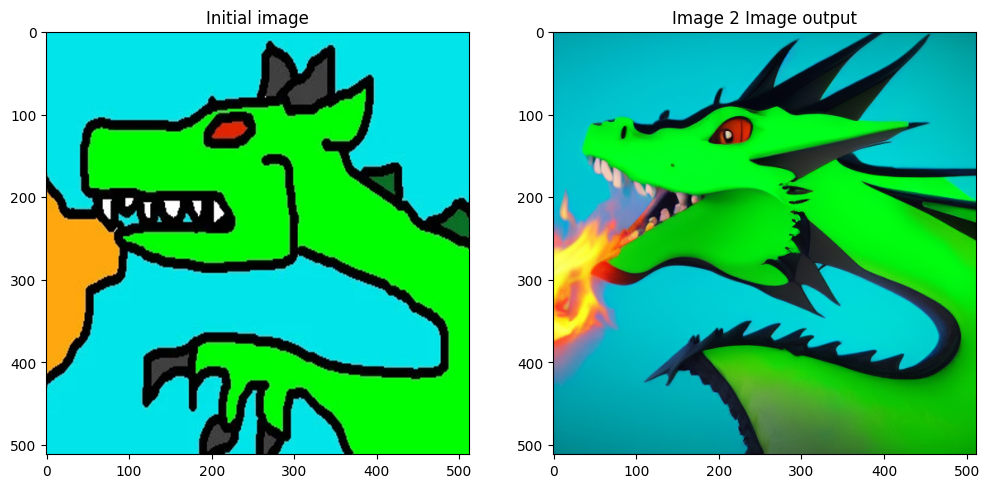

In [70]:
## Plotting side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for c, img in enumerate([image, images[0]]):
    axs[c].imshow(img)
    if c == 0 : axs[c].set_title(f"Initial image")
    else: axs[c].set_title(f"Image 2 Image output")

and that's it!

# Conclusion:

Using Hugging Face's diffusers is quite simple. You can also customize it and add features to it just as we did!

Feel free to utilize this code and experiment with generating your own images. If you have any feedback, don't hesitate to [contact me.](mailto:hamza.esaamaali@gmail.com)